In [14]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import os

## Build an unique dataset based on the PM25's median
1- Aggregate each data sensors hourly by applying a mean
2- Create an unique dataset by applying a median of each sensor in each hour

### Define constants

In [15]:
START_DATE_BOARD    = '2022-11-03'
END_DATE_BOARD      = '2023-06-15'
PM25_DIRECTORY      = '../resources/dataset/'
PM2_MAP = {
    "board20": ["s250.csv", "s252.csv", "s256.csv", "s258.csv"],
    "board21": ["s263.csv", "s265.csv", "s267.csv", "s269.csv"],
    "board22": ["s276.csv", "s278.csv", "s280.csv", "s282.csv"],
    "board25": ["s315.csv", "s317.csv", "s319.csv", "s321.csv"],
    "board29": ["s367.csv", "s369.csv", "s371.csv", "s373.csv"],
    "board31": ["s393.csv", "s395.csv", "s397.csv", "s399.csv"]
}

### Transform each CSV into Pandas dataframe

In [16]:
def change_hour_format(hour: str) -> str:
    return hour + ":00" if len(hour.split(':')) <= 2 else hour

def build_arpa_dataset(arpa_2022:str, arpa_2023:str) -> pd.DataFrame:
    df_arpa_2022 = pd.read_csv(arpa_2022, sep=';')
    df_arpa_2023 = pd.read_csv(arpa_2023, sep=';', index_col=False)
    df_arpa_2022.dropna(inplace=True)
    df_arpa_2023 = df_arpa_2023[df_arpa_2023.Stato == 'V']
    
    df_arpa = pd.DataFrame(columns=['timestamp', 'pm25'])
    data_series_2022 = df_arpa_2022['Data'] + " " + df_arpa_2022['Ora'].map(lambda x: change_hour_format(x))
    data_series_2023 = df_arpa_2023['Data rilevamento'] + ' ' + df_arpa_2023['Ora'].map(lambda x: change_hour_format(x))
    pm25_series = df_arpa_2022['PM2.5']
    
    data_series = pd.concat([data_series_2022, data_series_2023], ignore_index = True)
    pm25_series = pd.concat([pm25_series, df_arpa_2023['Valore']], ignore_index = True)
    
    df_arpa['timestamp']    = data_series
    df_arpa['pm25']         = pm25_series
    df_arpa.timestamp       = pd.to_datetime(df_arpa.timestamp, format="%d/%m/%Y %H:%M:%S")
    # Apply date range filter
    mask = (df_arpa['timestamp'] >= START_DATE_BOARD) & (df_arpa['timestamp'] <= END_DATE_BOARD)
    df_arpa = df_arpa.loc[mask]
    
    # Apply a special filter in which I remove all ARPA's values below 4
    df_arpa = df_arpa[df_arpa['pm25'] > 4]
    return df_arpa

df_arpa = build_arpa_dataset('../resources/dataset/arpa/Dati PM10_PM2.5_2020-2022.csv', '../resources/dataset/arpa/Torino-Rubino_Polveri-sottili_2023-01-01_2023-06-30.csv')

In [18]:
def prepare_pm25_dataframe(file_name: str) -> pd.DataFrame:
    df_pm25             = pd.read_csv(file_name) #mu_g/m^3
    df_pm25.timestamp   = pd.to_datetime(df_pm25.timestamp)
    df_pm25.drop_duplicates(inplace=True)
    df_pm25.sort_values(by='timestamp', inplace=True)
    df_pm25 = df_pm25.loc[(df_pm25['timestamp'] >= START_DATE_BOARD) & (df_pm25['timestamp'] <= END_DATE_BOARD)]
    df_pm25 = df_pm25.groupby(pd.Grouper(key='timestamp', freq='H')).mean().reset_index()
    df_pm25.dropna(inplace=True)
    return df_pm25

dataframes = []
for folder_name in tqdm(os.listdir(PM25_DIRECTORY), desc='Analyzing folders'):
    folder = os.path.join(PM25_DIRECTORY, folder_name)
    if os.path.isdir(folder) and len(folder.split('/')) > 3 and folder.split('/')[3] in PM2_MAP:
        files = PM2_MAP[folder.split('/')[3]]
        for file_name in files:
            file = os.path.join(folder, file_name)
            if os.path.isfile(file) and file.endswith(".csv"):
                df_pm25 = prepare_pm25_dataframe(file)
                dataframes.append(df_pm25)

Analyzing folders:   0%|          | 0/8 [00:00<?, ?it/s]

Start analyzing file ../resources/dataset/board22/s276.csv
Start analyzing file ../resources/dataset/board22/s278.csv
Start analyzing file ../resources/dataset/board22/s280.csv
Start analyzing file ../resources/dataset/board22/s282.csv


Analyzing folders:  12%|█▎        | 1/8 [00:24<02:52, 24.60s/it]

Start analyzing file ../resources/dataset/board25/s315.csv
Start analyzing file ../resources/dataset/board25/s317.csv
Start analyzing file ../resources/dataset/board25/s319.csv
Start analyzing file ../resources/dataset/board25/s321.csv


Analyzing folders:  25%|██▌       | 2/8 [03:00<10:10, 101.80s/it]

Start analyzing file ../resources/dataset/board31/s393.csv
Start analyzing file ../resources/dataset/board31/s395.csv
Start analyzing file ../resources/dataset/board31/s397.csv
Start analyzing file ../resources/dataset/board31/s399.csv


Analyzing folders:  62%|██████▎   | 5/8 [04:23<02:26, 48.82s/it] 

Start analyzing file ../resources/dataset/board20/s250.csv
Start analyzing file ../resources/dataset/board20/s252.csv
Start analyzing file ../resources/dataset/board20/s256.csv
Start analyzing file ../resources/dataset/board20/s258.csv


Analyzing folders:  75%|███████▌  | 6/8 [05:15<01:39, 49.66s/it]

Start analyzing file ../resources/dataset/board29/s367.csv
Start analyzing file ../resources/dataset/board29/s369.csv
Start analyzing file ../resources/dataset/board29/s371.csv
Start analyzing file ../resources/dataset/board29/s373.csv


Analyzing folders:  88%|████████▊ | 7/8 [07:18<01:08, 68.99s/it]

Start analyzing file ../resources/dataset/board21/s263.csv
Start analyzing file ../resources/dataset/board21/s265.csv
Start analyzing file ../resources/dataset/board21/s267.csv
Start analyzing file ../resources/dataset/board21/s269.csv


Analyzing folders: 100%|██████████| 8/8 [08:50<00:00, 66.34s/it]


### Get an unique dataframe by applying the median in each point

In [62]:
df_pm25                 = pd.DataFrame(columns=['timestamp', 'data'])
df_pm25['timestamp']    = pd.date_range(start=START_DATE_BOARD, end=END_DATE_BOARD, freq='H')
pm25_series             = []

for pit in tqdm(df_pm25['timestamp'], desc='Building unique dataset'):
    pm25_values = []
    for df in dataframes:
        value = df[df.timestamp == pit]['data'].values
        if len(value) > 0:
            pm25_values.append(value[0])
        #else:
        #    pm25_values.append(0)
    pm25_series.append(np.median(pm25_values) if len(pm25_values) > 0 else None)

df_pm25['data']    = pd.Series(pm25_series)
df_pm25.dropna(inplace=True)
df_pm25.to_csv('../resources/dataset/unique_timeserie_by_median.csv', index=False)

Building unique dataset: 100%|██████████| 5377/5377 [01:15<00:00, 70.76it/s]


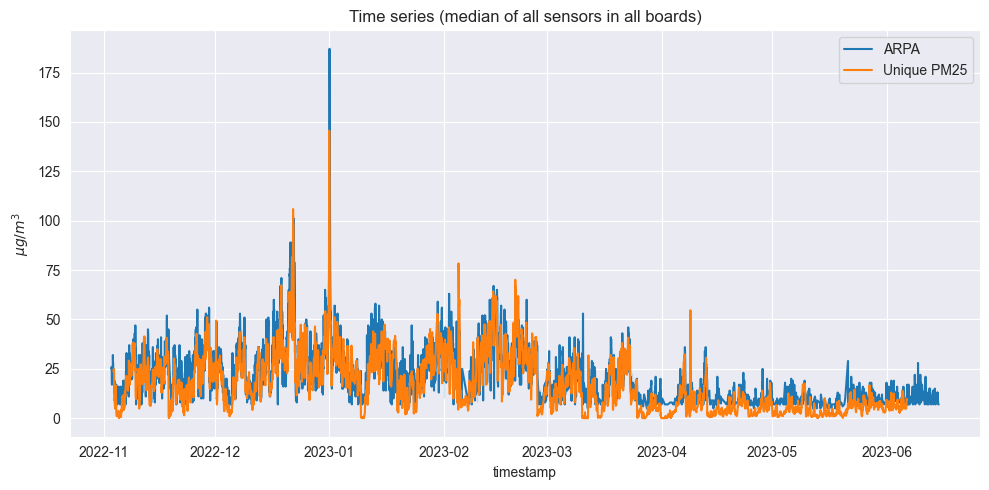

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(x = "timestamp", y = "pm25", data = df_arpa, ax=ax, label='ARPA')
sns.lineplot(x = "timestamp", y = "data", data = df_pm25, ax=ax, label='Unique PM25')
ax.set_ylabel(r'$\mu g/m^3$')
ax.set_title('Time series (median of all sensors in all boards)')
ax.grid()
plt.grid()
fig.tight_layout()
plt.show()

## Start with LSTM model

In [39]:
import torch
import torch.nn as nn
from datetime import datetime
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SequentialSampler

torch.manual_seed(1)

### Prepare dataset

In [44]:
df_sensors              = pd.read_csv('../resources/dataset/unique_timeserie_by_median.csv')
df_sensors.timestamp    = pd.to_datetime(df_sensors.timestamp)
df_arpa                 = build_arpa_dataset('../resources/dataset/arpa/Dati PM10_PM2.5_2020-2022.csv'
                                     , '../resources/dataset/arpa/Torino-Rubino_Polveri-sottili_2023-01-01_2023-06-30.csv')

df          = df_sensors.merge(df_arpa, left_on=['timestamp'], right_on=['timestamp'])
df.rename(columns={"data": "x", "pm25": "y"}, inplace=True)
# Add month column and transform it into one-hot-encording
df['month'] = df.timestamp.dt.month
# Add the moment of the day
def get_period_of_the_day(timestamp):
    h = timestamp.hour
    if 0 <= h <= 6:
        return 1
    elif 7 <= h <= 12:
        return 2
    elif 13 <= h <= 18:
        return 3
    else:
        return 4
df['period_day'] = df['timestamp'].map(get_period_of_the_day)
# Transform some features into one-hot encoding
df          = pd.get_dummies(df, columns = ['month', 'period_day'])

TRAIN_SIZE  = 0.8
T           = 5 # the number of hours to look for prediction

input_data  = df.drop(['timestamp', 'y'], axis=1)
targets     = df.y.values
D           = input_data.shape[1] # Dimensionality of the input
N           = len(input_data) - T

train_size  = int(len(input_data) * TRAIN_SIZE)
# Preparing X_train and y_train
X_train     = np.zeros((train_size, T, D))
y_train     = np.zeros((train_size, 1))
for t in range(train_size):
    X_train[t, :, :] = input_data[t:t+T]
    y_train[t] = (targets[t+T])

# Preparing X_test and y_test
X_test      = np.zeros((N - train_size, T, D))
y_test      = np.zeros((N - train_size, 1))
for i in range(N - train_size):
    t = i + train_size
    X_test[i, :, :] = input_data[t:t+T]
    y_test[i] = (targets[t+T])

# Make inputs and targets
X_train     = torch.from_numpy(X_train.astype(np.float32))
y_train     = torch.from_numpy(y_train.astype(np.float32))
X_test      = torch.from_numpy(X_test.astype(np.float32))
y_test      = torch.from_numpy(y_test.astype(np.float32))

### Create the model structure

In [47]:
class MyLSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(MyLSTM, self).__init__()
        self.M = hidden_dim
        self.L = layer_dim

        self.rnn = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=layer_dim,
            batch_first=True)
        # batch_first to have (batch_dim, seq_dim, feature_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, X):
        # initial hidden state and cell state
        h0 = torch.zeros(self.L, X.size(0), self.M)
        c0 = torch.zeros(self.L, X.size(0), self.M)

        out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

        # h(T) at the final time step
        out = self.fc(out[:, -1, :])
        return out

### Train the model

In [48]:
# Define the hyperparameters
INPUT_SIZE      = D
HIDDEN_SIZE     = 512
OUTPUT_SIZE     = 1
LEARNING_RATE   = 0.01
NUM_EPOCHS      = 50

# Instantiate the model
model           = MyLSTM(D, HIDDEN_SIZE, 2, OUTPUT_SIZE)

# Define the loss function and optimizer
criterion       = nn.MSELoss()
optimizer       = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)

In [49]:
# Train the model
train_losses    = np.zeros(NUM_EPOCHS)
for epoch in tqdm(range(NUM_EPOCHS), desc='Train the model'):
    optimizer.zero_grad()

    # Forward pass
    outputs     = model(X_train)
    loss        = criterion(outputs, y_train)

    # Backpropagation
    loss.backward()
    optimizer.step()
    train_losses[epoch] = loss.item()

    #if (epoch + 1) % 50 == 0:
    #    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, NUM_EPOCHS, loss.item()))

Train the model: 100%|██████████| 50/50 [18:35<00:00, 22.32s/it]


### Draw the train loss at each iteration

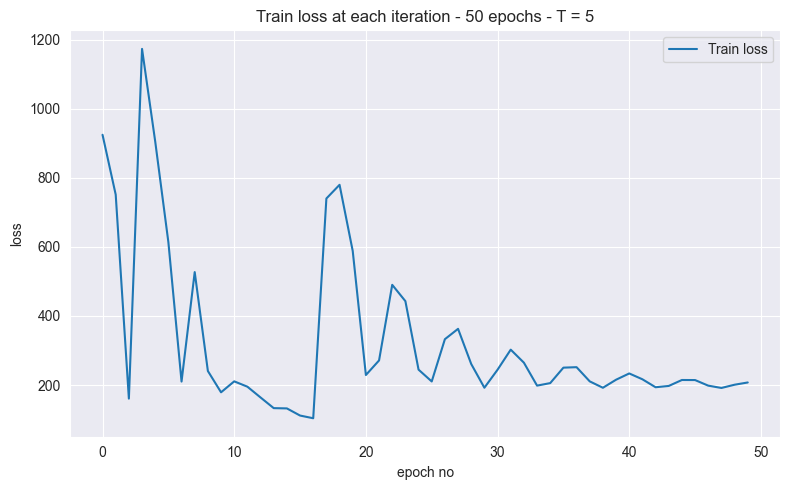

In [50]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train_losses, label='Train loss')
ax.set_xlabel('epoch no')
ax.set_ylabel('loss')
ax.set_title(f'Train loss at each iteration - {NUM_EPOCHS} epochs - T = {T}')
ax.legend()
plt.tight_layout()
plt.show()

### Draw the performance of LSTM model

In [51]:
test_target         = y_test.cpu().detach().numpy()
test_predictions    = []

for i in tqdm(range(len(test_target)), desc='Preparing predictions'):
    input_  = X_test[i].reshape(1, T, D)
    p       = model(input_)[0,0].item()
    test_predictions.append(p)

plot_len        = len(test_predictions)
plot_df         = df[['timestamp', 'y']].copy(deep=True)
plot_df         = plot_df.iloc[-plot_len:]
plot_df['pred'] = test_predictions
plot_df.set_index('timestamp', inplace=True)

Preparing predictions: 100%|██████████| 732/732 [00:03<00:00, 203.62it/s]


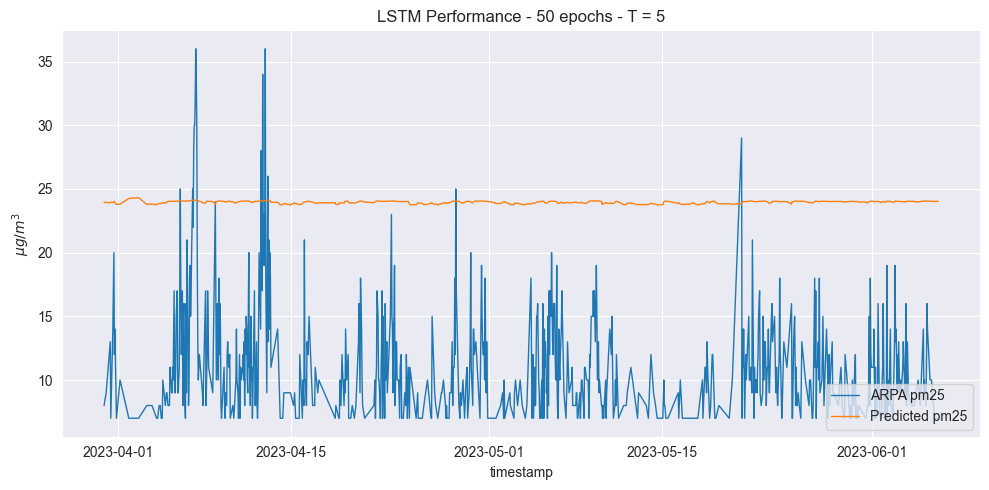

In [52]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(plot_df['y'], label='ARPA pm25', linewidth=1)
ax.plot(plot_df['pred'], label='Predicted pm25', linewidth=1)
ax.set_xlabel('timestamp')
ax.set_ylabel(r'$\mu g/m^3$')
ax.set_title(f'LSTM Performance - {NUM_EPOCHS} epochs - T = {T}')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()